In [40]:
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.simulator import Simulator, generate_sim_config
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer
from deorbit.utils.constants import EARTH_RADIUS
from deorbit.utils.plotting import plot_trajectories


In [2]:
save_path = "eg/EKF_example_3D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

np.random.seed(0)
start_direction = np.random.normal(size=2)
start_direction /= np.linalg.norm(start_direction)
if sim_data is None or sim_config is None:
    rollout_sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 0, *(start_direction * 7820))),
        noise_types = {"gaussian": {"noise_strength": 0.001}, "impulse": {"impulse_strength": 0.005, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = rollout_sim.gather_data()
    sim_config = rollout_sim.export_config()
    rollout_sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


In [19]:
def calculate_total_error(sim_states, sim_times, estimated_states):
    dim = int(sim_states.shape[1] / 2)
    length = min(len(sim_states), len(estimated_states))
    sim_states = sim_states[:length]
    estimated_states = estimated_states[:length]
    sim_times = sim_times[:length]
    abs_error = np.linalg.norm((sim_states - estimated_states)[:,:dim], axis=1)
    return np.trapz(abs_error, sim_times)

def calculate_avg_error(sim_states, sim_times, estimated_states):
    total_error = calculate_total_error(sim_states, sim_times, estimated_states)
    length = min(len(sim_states), len(estimated_states))
    return total_error / sim_times[length-1]

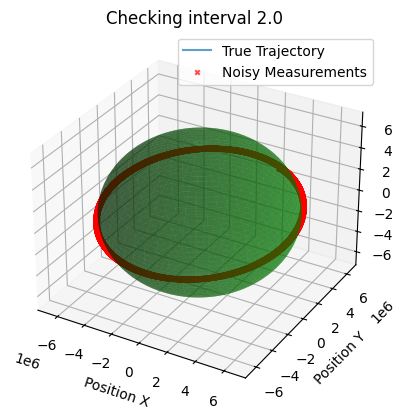

 37%|███▋      | 4994/13540 [00:02<00:04, 1830.91it/s]


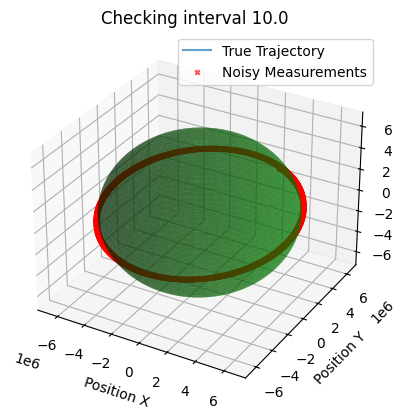

 37%|███▋      | 998/2701 [00:02<00:04, 416.42it/s]


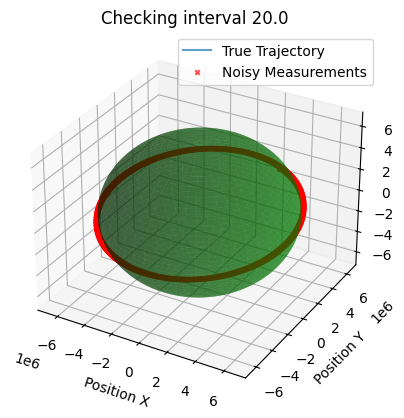

 37%|███▋      | 501/1358 [00:02<00:04, 199.80it/s]


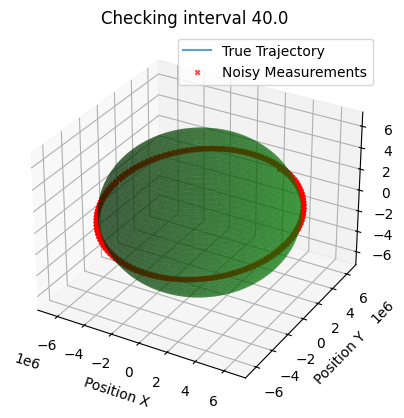

 37%|███▋      | 251/678 [00:02<00:03, 111.22it/s]


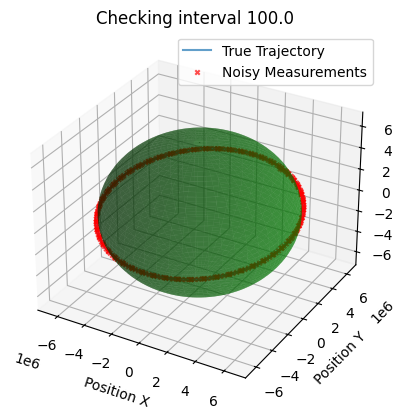

 37%|███▋      | 101/272 [00:02<00:03, 43.64it/s]


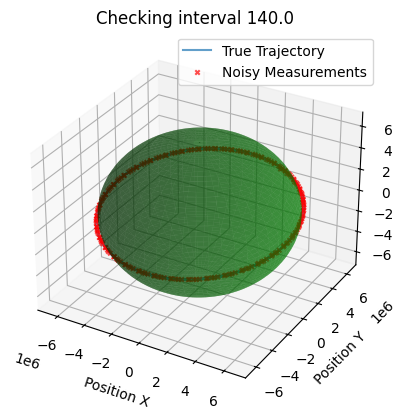

 37%|███▋      | 72/194 [00:02<00:03, 32.62it/s]


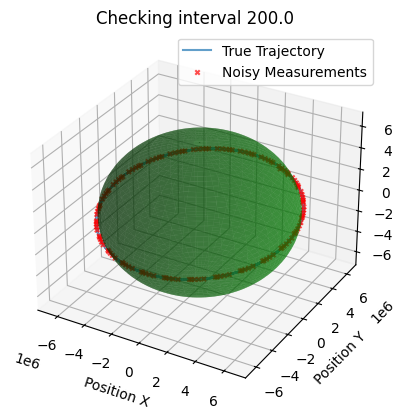

 37%|███▋      | 51/137 [00:02<00:04, 21.04it/s]


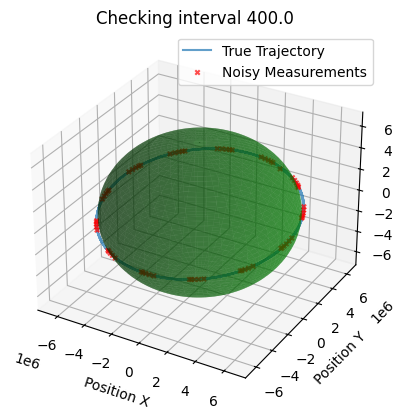

 38%|███▊      | 26/69 [00:02<00:04, 10.66it/s]


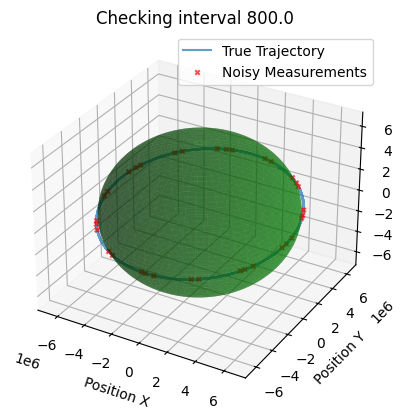

 38%|███▊      | 13/34 [00:02<00:03,  5.86it/s]


In [43]:
#initialising observer class with sim data
avg_error = {}
checking_intervals = [1, 5, 10, 20, 50, 70, 100, 200, 400]
for ci in checking_intervals:
    np.random.seed(4)
    obs = Observer(number_of_radars=500, dim=3, radar_position_std_per_distance=1e-4)

    sim_states = sim_data.state_array()
    sim_times = sim_data.times

    obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=ci)

    observation_times = obs.observed_times
    observation_states = obs.observed_states
    observed_covariances = obs.observed_covariances

    observations = (observation_states, observation_times)
    
    plot_trajectories(sim_states, observations=observation_states, title=f"Checking interval {ci * sim_config.simulation_method_kwargs.time_step}")

    # Define process and measurement noise covariance matrices, think this noise should be alot bigger
    Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
    P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

    # Measurement matrix H (assuming all states are measured directly??????) -- for now
    H = np.eye(sim_data.state_array().shape[1])

    dt = sim_config.simulation_method_kwargs.time_step

    #initialising 3D EKF
    ekf = EKF(dim=3)

    estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H, steps=5000)
    avg_error[ci] = calculate_total_error(sim_states, sim_times, estimated_traj)
    

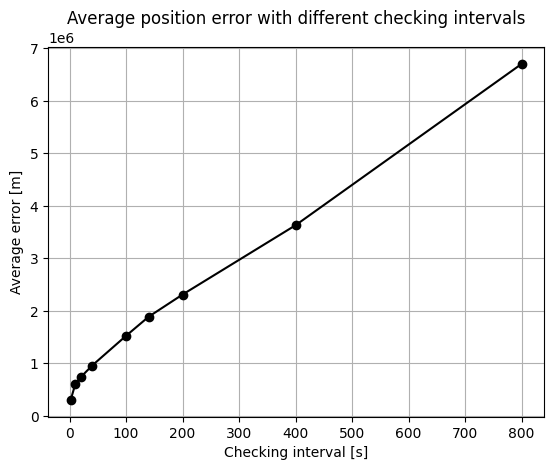

In [44]:
fig, ax = plt.subplots()
time_checking_intervals = np.array(checking_intervals) * sim_config.simulation_method_kwargs.time_step
ax.plot(time_checking_intervals, list(avg_error.values()), marker='o', color="k")
ax.set_xlabel("Checking interval [s]")
ax.set_ylabel("Average error [m]")
ax.set_title("Average position error with different checking intervals")
ax.grid()